In [1]:
#Import datasets
from Dataset import Dataset, Explorer

datasets = [
            "876eedf5-4f78-4e61-aa0a-2a322e277922", # (0) Vessel Calls (>75 GT), Monthly
            "1128e807-b450-436f-a7c7-8970b5273434", # (1) Vessel Arrivals (>75 GT), Monthly
            "8b416bcb-7ab5-4650-8996-88fe629acebe", # (2) Job Vacancy Rate by Industry and Occupational Group, Quarterly
            "655a1c84-d371-4fb3-81b1-cf80f65b8052", # (3) Short Work-Week & Temporary Layoffs By Industry, Quarterly
            "64bede5b-353f-4be2-9321-91eadf3f92a2", # (4) Short Work-Week & Temporary Layoffs By Occupational Group, Quarterly
           ]

def main():
    for d,dset in enumerate(datasets):
        datasets[d] = Dataset(dset)
    print("All done!")
        
if __name__ == "__main__":
    main()

[876eedf5-4f78-4e61-aa0a-2a322e277922] Fetching metadata via API
[Vessel Calls (>75 GT), Monthly] Fetching data via API
[Vessel Calls (>75 GT), Monthly] Parsing metadata
[Vessel Calls (>75 GT), Monthly] Parsing data
[Vessel Calls (>75 GT), Monthly] Converting data to Pandas DataFrame
[Vessel Calls (>75 GT), Monthly] Column "purpose_type" does not appear to be numeric. Pandas says: "Unable to parse string "Supplies" at position 0"
[Vessel Calls (>75 GT), Monthly] Loaded
[1128e807-b450-436f-a7c7-8970b5273434] Fetching metadata via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Fetching data via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing metadata
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing data
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Converting data to Pandas DataFrame
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Column "vessel_type" does not appear to be numeric. Pandas says: "Unable to parse string "Tug" at position 0"
[Vessel Arrivals (>75 GT) Breakdo

# Data prep

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

data = {
    "cls": {
        "df":datasets[0].dataframe,
        "label":"Vessel Calls (>75 GT), Monthly"
    },
    "arr":{
        "df":datasets[1].dataframe,
        "label":"Vessel Arrivals (>75 GT), Monthly"
    },
    "vac":{
        "df":datasets[2].dataframe,
        "label":"Job Vacancy Rate by Industry and Occupational Group, Quarterly"
    },
    "loi":{
        "df":datasets[3].dataframe,
        "label":"Short Work-Week & Temporary Layoffs By Industry, Quarterly"
    },
    "log":{
        "df":datasets[4].dataframe,
        "label":"Short Work-Week & Temporary Layoffs By Occupational Group, Quarterly"
    },
}

def dataset_aggregate_by_month(dataset,key):
    df = dataset["df"].copy()
    #Standardize columns for calls and arrivals
    if "number_of_vessel_calls" in df.columns:
        df = df.rename(columns={"number_of_vessel_calls":"number_of_vessels"})
    #Create aggregated total by month across types/purposes
    return {
        "df": df.groupby(df['month']).aggregate({'gross_tonnage': 'sum', 'month': 'first', 'number_of_vessels': 'sum'}).reset_index(drop=True),
        "label": f'{data[key]["label"]}, Total'
    }
    
def dataset_monthly_to_quarterly(dataset,key):
    df = dataset["df"].copy()
    df["quarter"] = pd.to_datetime(df["month"].map(lambda date: f'{date.year}-{date.quarter * 3:02d}-{date.day:02d}'))
    df = df.groupby(df['quarter']).sum()
    #Add key to column names so that we can tell the difference between arrivals and calls data in the final merged dataset
    for column in df.columns:
        df = df.rename(columns={column:f'{column}_{key}'})
    df["quarter"] = df.index
    return {
       "df": df.reset_index(drop=True),
       "label": data[f'{key}_agg']["label"].replace("Monthly","Quarterly")
    }

#Create total and quarterly calls and arrivals
monthly = ["cls","arr"]
for key in monthly:
    data[f'{key}_agg'] = dataset_aggregate_by_month(data[key],key)
    #Create special aggregation for non-passenger vessel arrivals
    if "vessel_type" in data[key]["df"].columns:
        data[f'{key}_agg_np'] = dataset_aggregate_by_month(data[key],key)
    #Roll up aggregated data by quarters
    data[f'{key}_q'] = dataset_monthly_to_quarterly(data[f'{key}_agg'],key)
    #Create special quarterly aggregation for non-passenger vessel arrivals
    if "vessel_type" in data[key]["df"].columns:
        data[f'{key}_q_np'] = dataset_monthly_to_quarterly(data[f'{key}_agg_np'],key)
    
#Sort data by date
for key in data:
    df = data[key]["df"]
    df.sort_values(by=("month" if "month" in df.columns else "quarter"),ascending=True,inplace=True)

#Create merged quarterly shipping dataframe
data["shp"] = {
    "df":reduce(lambda  left,right: pd.merge(left,right,on=['quarter'],how='outer'), [dataset for dataset in [data["cls_q"]["df"],data["arr_q"]["df"]]]),
    "label":"Shipping, Quarterly, Total"
}

#for dataset in data.items():
#    print(f'{dataset[1]["label"]} ({dataset[0]}): {dataset[1]["df"].columns}')



# Charting

## Arrivals, Vessels and Tonnage by Type

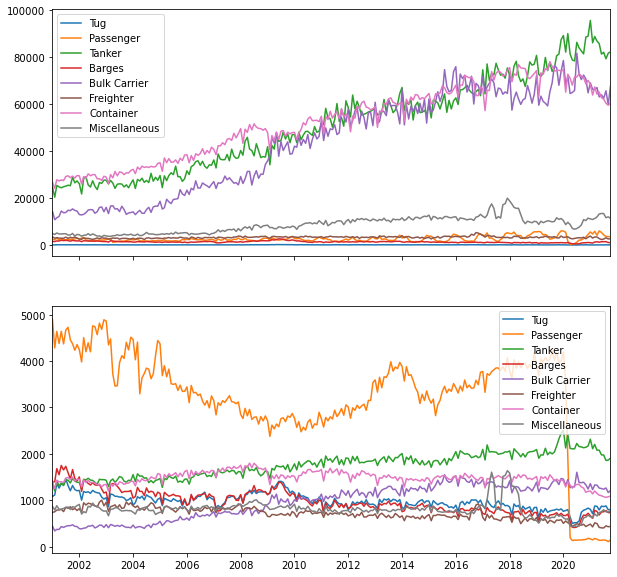

In [85]:
ts_fig, ts_ax = plt.subplots(2, 1, sharex=True,figsize = (10,10))
plt.xlim([pd.to_datetime("2001-01-01"),pd.to_datetime("2021-10-01")])
for vtype in data["arr"]["df"]["vessel_type"].unique():
    plot_0 = ts_ax[0].plot("month","gross_tonnage",data=data["arr"]["df"][data["arr"]["df"]["vessel_type"] == vtype],label=vtype)
    plot_1 = ts_ax[1].plot("month","number_of_vessels",data=data["arr"]["df"][data["arr"]["df"]["vessel_type"] == vtype],label=vtype)
    ts_ax[0].legend()
    ts_ax[1].legend()

## Total Arrivals, Vessels and Tonnage

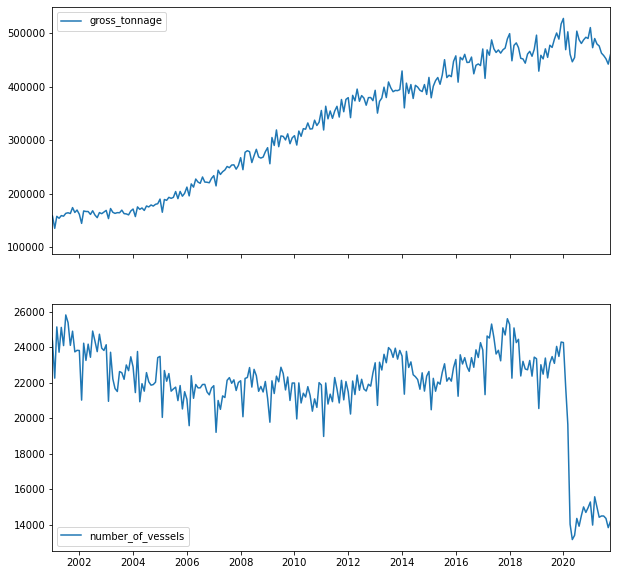

In [89]:
ts_fig, ts_ax = plt.subplots(2, 1, sharex=True,figsize = (10,10))
plt.xlim([pd.to_datetime("2001-01-01"),pd.to_datetime("2021-10-01")])
plot_0 = ts_ax[0].plot("month","gross_tonnage",data=data["arr_agg"]["df"])
plot_1 = ts_ax[1].plot("month","number_of_vessels",data=data["arr_agg"]["df"])
ts_ax[0].legend()
ts_ax[1].legend()

## Non-passenger Arrivals, Vessels and Tonnage

The below charts show arrivals tonnage and total number of vessels for all arrivals not labelled with vessel_type = "Passenger" 

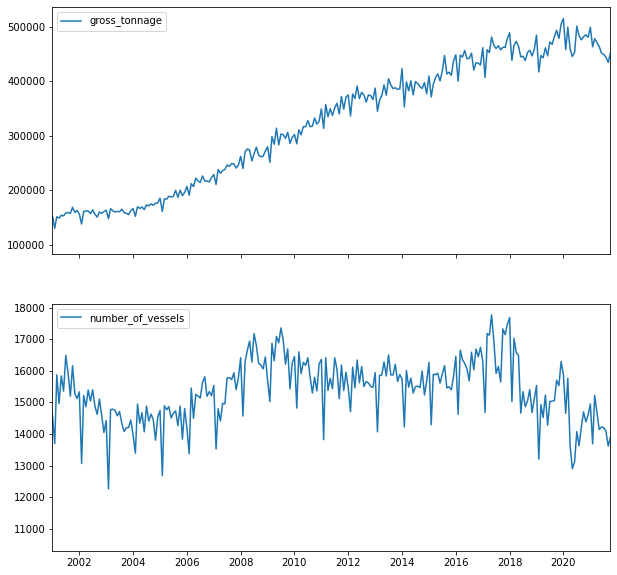

In [96]:
ts_fig, ts_ax = plt.subplots(2, 1, sharex=True,figsize = (10,10))
plt.xlim([pd.to_datetime("2001-01-01"),pd.to_datetime("2021-10-01")])
plot_0 = ts_ax[0].plot("month","gross_tonnage",data=data["arr_agg_np"]["df"])
plot_1 = ts_ax[1].plot("month","number_of_vessels",data=data["arr_agg_np"]["df"])
ts_ax[0].legend()
ts_ax[1].legend()

## Non-passenger arrivals and temporary layoffs, by industry

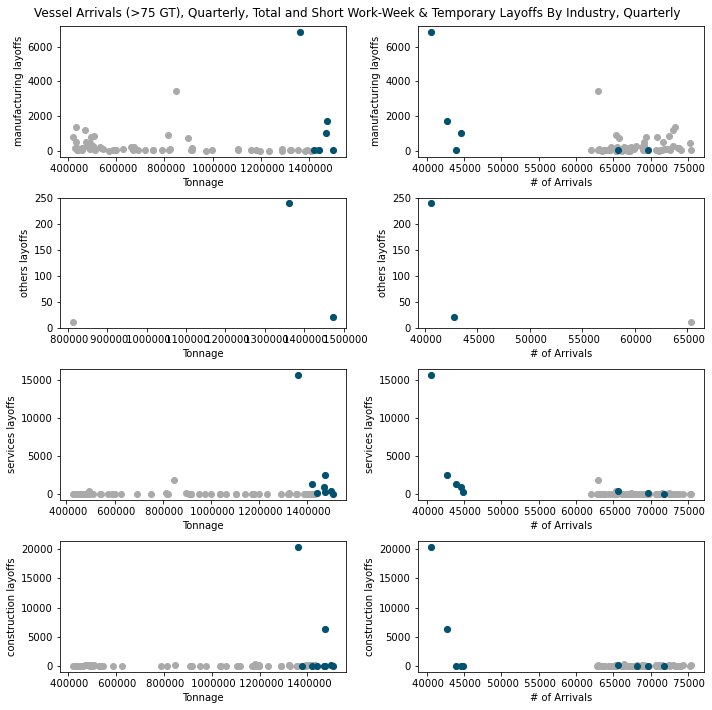

In [166]:
from matplotlib.ticker import FormatStrFormatter

df_arr_loi = data["arr_q_np"]["df"].merge(data["loi"]["df"],on="quarter")
df_arr_loi_covid = df_arr_loi[df_arr_loi["quarter"] > pd.to_datetime("2019-03-01")]

sc_fig, sc_ax = plt.subplots(rows,2,figsize=(10,10))
sc_fig.suptitle(data["arr_q_np"]["label"]+" and "+data["loi"]["label"])
industries = df_arr_loi["industry1"].unique()
rows = len(industries)
row = 0
plots = [("gross_tonnage_arr","Tonnage"),("number_of_vessels_arr","# of Arrivals")]
for industry in industries:
    for p,plot in enumerate(plots):
        sc_ax[row][p].scatter(plot[0],"temporary_layoff",data=df_arr_loi[df_arr_loi["industry1"] == industry],color="#aaa")
        sc_ax[row][p].scatter(plot[0],"temporary_layoff",data=df_arr_loi_covid[df_arr_loi_covid["industry1"] == industry],color="#005271")
        sc_ax[row][p].set_ylabel(f'{industry} layoffs')
        sc_ax[row][p].set_xlabel(plot[1])
        sc_ax[row][p].xaxis.set_major_formatter(FormatStrFormatter('% .0f'))
    row += 1
sc_fig.tight_layout(pad=1.0)

## Non-passenger arrivals and short work weeks, by industry

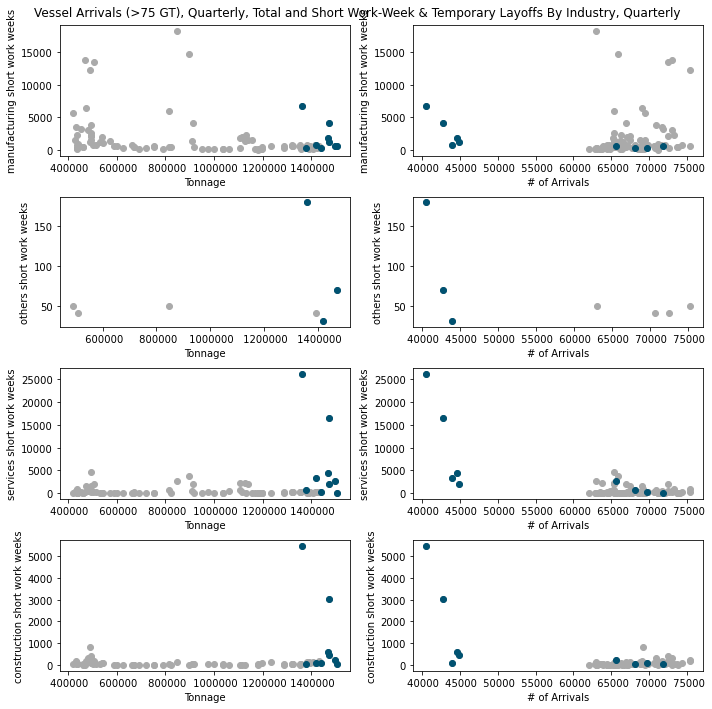

In [167]:
from matplotlib.ticker import FormatStrFormatter

df_arr_loi = data["arr_q_np"]["df"].merge(data["loi"]["df"],on="quarter")
df_arr_loi_covid = df_arr_loi[df_arr_loi["quarter"] > pd.to_datetime("2019-03-01")]

sc_fig, sc_ax = plt.subplots(rows,2,figsize=(10,10))
sc_fig.suptitle(data["arr_q_np"]["label"]+" and "+data["loi"]["label"])
industries = df_arr_loi["industry1"].unique()
rows = len(industries)
row = 0
plots = [("gross_tonnage_arr","Tonnage"),("number_of_vessels_arr","# of Arrivals")]
for industry in industries:
    for p,plot in enumerate(plots):
        sc_ax[row][p].scatter(plot[0],"short_work_week",data=df_arr_loi[df_arr_loi["industry1"] == industry],color="#aaa")
        sc_ax[row][p].scatter(plot[0],"short_work_week",data=df_arr_loi_covid[df_arr_loi_covid["industry1"] == industry],color="#005271")
        sc_ax[row][p].set_ylabel(f'{industry} short work weeks')
        sc_ax[row][p].set_xlabel(plot[1])
        sc_ax[row][p].xaxis.set_major_formatter(FormatStrFormatter('% .0f'))
    row += 1
sc_fig.tight_layout(pad=1.0)

## Non-passenger arrivals and job vacancy rate, by industry

<ipython-input-171-933df8bccd8d>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_arr_vac_covid = df_arr_loi[df_arr_vac["quarter"] > pd.to_datetime("2019-03-01")]


      gross_tonnage_arr  number_of_vessels_arr    quarter  job_vacancy_rate  \
0             342412.26                  50158 1995-03-01               4.0   
1             342412.26                  50158 1995-03-01               4.8   
2             342412.26                  50158 1995-03-01               2.9   
3             342412.26                  50158 1995-03-01               6.0   
4             342412.26                  50158 1995-03-01              11.1   
...                 ...                    ...        ...               ...   
3255         1419030.64                  43916 2021-06-01               3.6   
3256         1419030.64                  43916 2021-06-01               5.4   
3257         1419030.64                  43916 2021-06-01               4.7   
3258         1419030.64                  43916 2021-06-01               3.7   
3259         1419030.64                  43916 2021-06-01              11.6   

                                            industr

ValueError: x and y must be the same size

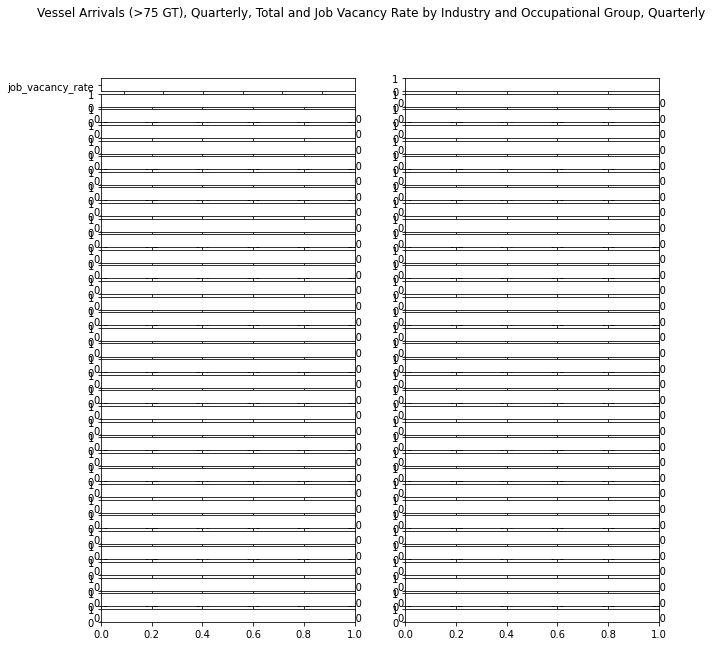

In [171]:
from matplotlib.ticker import FormatStrFormatter

df_arr_vac = data["arr_q_np"]["df"].merge(data["vac"]["df"],on="quarter")
df_arr_vac_covid = df_arr_loi[df_arr_vac["quarter"] > pd.to_datetime("2019-03-01")]

print(df_arr_vac)

sc_fig, sc_ax = plt.subplots(rows,2,figsize=(10,10))
sc_fig.suptitle(data["arr_q_np"]["label"]+" and "+data["vac"]["label"])
industries = df_arr_vac["industry1"].unique()
rows = len(industries)
row = 0
plots = [("gross_tonnage_arr","Tonnage"),("number_of_vessels_arr","# of Arrivals")]
for industry in industries:
    for p,plot in enumerate(plots):
        sc_ax[row][p].scatter(plot[0],"job_vacancy_rate",data=df_arr_vac[df_arr_vac["industry1"] == industry],color="#aaa")
        sc_ax[row][p].scatter(plot[0],"job_vacancy_rate",data=df_arr_vac_covid[df_arr_vac_covid["industry1"] == industry],color="#005271")
        sc_ax[row][p].set_ylabel(f'{industry} job vacancy rate')
        sc_ax[row][p].set_xlabel(plot[1])
        sc_ax[row][p].xaxis.set_major_formatter(FormatStrFormatter('% .0f'))
    row += 1
sc_fig.tight_layout(pad=1.0)

## Non Passenger Arrivals Analysis

**Initial Observation:** Some types of non-passenger arrivals fell during COVID-19, but others stayed steady or even went up. 

In [29]:
# Convert to shorter df name for easy handling 

# arr by vessel type
arr_df1 = data['arr']['df']
arr_df2 = arr_df1[arr_df1['vessel_type'] != 'Passenger']
arr_gb = arr_df2.groupby(['vessel_type', 'month']).sum()
arr_gbdf = pd.DataFrame(arr_gb)
arr_gbdf1 = arr_gbdf.reset_index()

# for number vessels pivot by vessel type
arr_piv = arr_gbdf1.pivot('month', 'vessel_type', 'number_of_vessels')
arr_piv1 = pd.DataFrame(arr_piv)
arr_df = arr_piv1.reset_index()
arr_df['total'] = arr_df['Barges'] + arr_df['Bulk Carrier'] + arr_df['Container'] + arr_df['Freighter'] + arr_df['Miscellaneous'] + arr_df['Tanker'] + arr_df['Tug']

# for gross tonnage pivot by vessel type
arr_pivg = arr_gbdf1.pivot('month', 'vessel_type', 'gross_tonnage')
arr_piv1g = pd.DataFrame(arr_pivg)
arr_dfg = arr_piv1g.reset_index()
arr_dfg['total_gt'] = arr_dfg['Barges'] + arr_dfg['Bulk Carrier'] + arr_dfg['Container'] + arr_dfg['Freighter'] + arr_dfg['Miscellaneous'] + arr_dfg['Tanker'] + arr_dfg['Tug']


# # arr total per month number of vessels 
# #arr_df_tot = data['arr_agg']['df']
# #arr_df_tot.head()
# arr_pivt = arr_gbdf1.pivot('month', 'vessel_type', 'number_of_vessels')
# arr_piv1t = pd.DataFrame(arr_piv)
# arr_dfnew = arr_piv1.reset_index()
# arr_dfnew['total'] = arr_dfnew['Barges'] + arr_dfnew['Bulk Carrier'] + arr_dfnew['Container'] + arr_dfnew['Freighter'] + arr_dfnew['Miscellaneous'] + arr_dfnew['Tanker'] + arr_dfnew['Tug']
# arr_df_tot = arr_dfnew

# # arr total per month gross tonnage
# arr_pivtg = arr_gbdf1.pivot('month', 'vessel_type', 'gross_tonnage')
# arr_piv1tg = pd.DataFrame(arr_piv)
# arr_dfnewg = arr_piv1.reset_index()
# arr_dfnewg['total'] = arr_dfnewg['Barges'] + arr_dfnewg['Bulk Carrier'] + arr_dfnewg['Container'] + arr_dfnewg['Freighter'] + arr_dfnewg['Miscellaneous'] + arr_dfnewg['Tanker'] + arr_dfnewg['Tug']
# arr_df_totgt = arr_dfnewg


# arr by vessel type covid subset (2019-present)
is_covid = arr_df['month'] >= '2018-06-01'
# vessel number
arr_ss = arr_df[is_covid]
# gross tonnage
arr_ssg = arr_dfg[is_covid]

# # arr total covid subset (2019-present)
# is_covid2 = arr_df_tot['month'] >= '2018-06-01'
# arr_ss_tot = arr_df_tot[is_covid2]
# arr_ss_totgt = arr_df_totgt[is_covid2]

In [30]:
#arr_df.head()

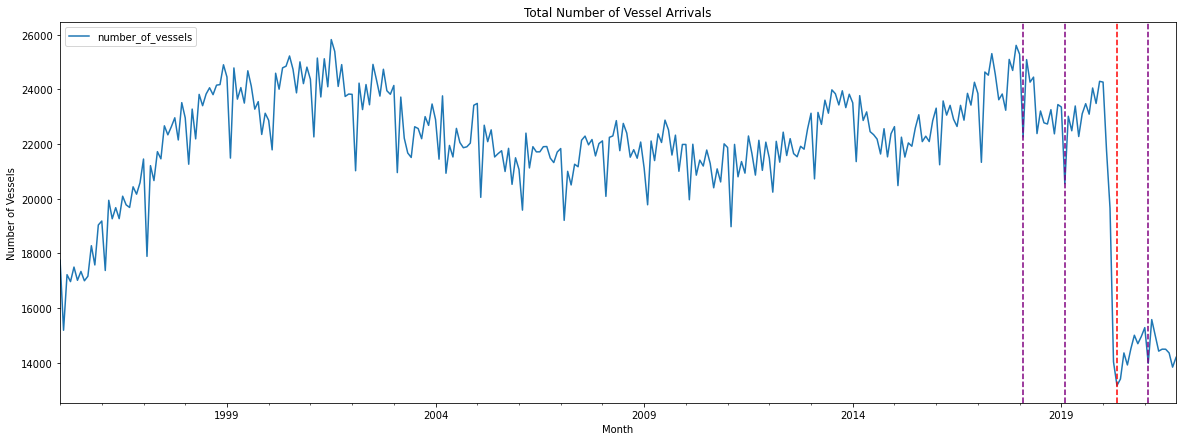

In [5]:
# Total Arrivals with pasengers 
arr_df_totp = data['arr_agg']['df']
fig_01 = arr_df_totp.plot("month", "number_of_vessels", figsize = (20,7))
fig_01.set_title('Total Number of Vessel Arrivals')
fig_01.set_xlabel('Month')
fig_01.set_ylabel('Number of Vessels')
fig_01.axvline("2018-02-01", color="purple", linestyle="dashed")
fig_01.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_01.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_01.axvline("2020-05-01", color="red", linestyle="dashed")

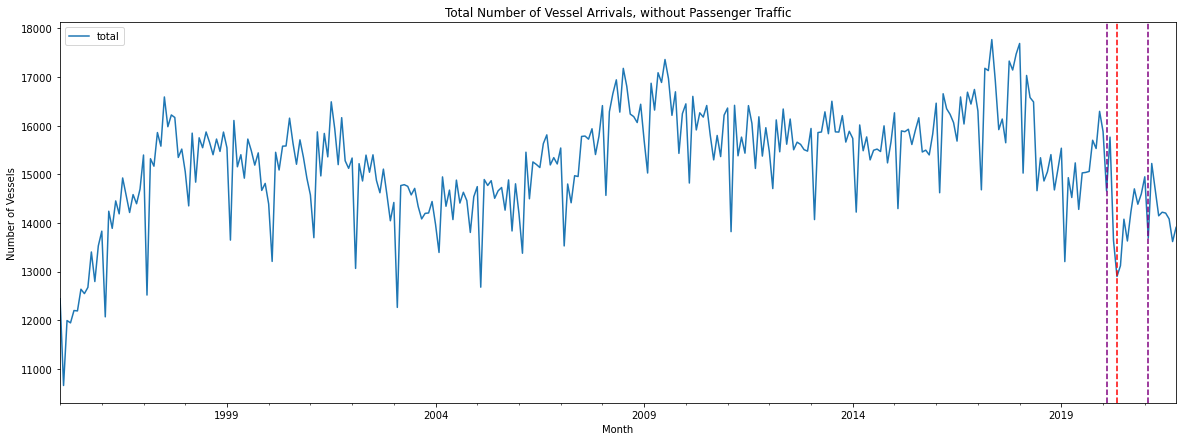

In [31]:
# Total Arrivals w/o passengers
fig_1 = arr_df.plot("month", "total", figsize = (20,7))
fig_1.set_title('Total Number of Vessel Arrivals, without Passenger Traffic')
fig_1.set_xlabel('Month')
fig_1.set_ylabel('Number of Vessels')
fig_1.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_1.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_1.axvline("2020-05-01", color="red", linestyle="dashed")

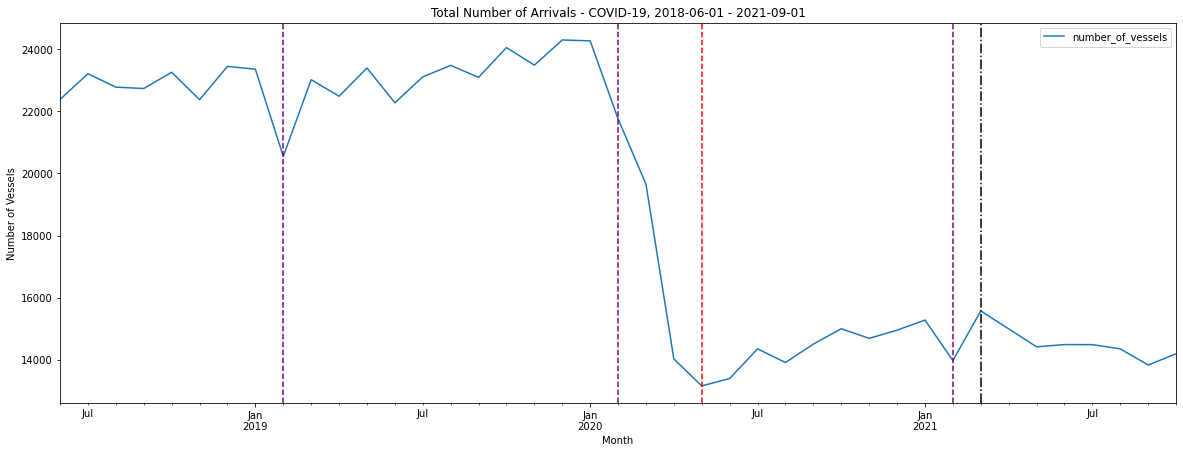

In [7]:
# Total Arrivals - COVID-19
arr_df_totp = data['arr_agg']['df']
is_covid02 = arr_df_totp['month'] >= '2018-06-01'
arr_ss_totp = arr_df_totp[is_covid02]
fig_02 = arr_ss_totp.plot("month", "number_of_vessels", figsize = (20,7))
fig_02.set_title('Total Number of Arrivals - COVID-19, 2018-06-01 - 2021-09-01')
fig_02.set_xlabel('Month')
fig_02.set_ylabel('Number of Vessels')
fig_02.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_02.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_02.axvline("2020-05-01", color="red", linestyle="dashed")
fig_02.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_02.axvline("2021-03-01", color="black", linestyle="dashdot")

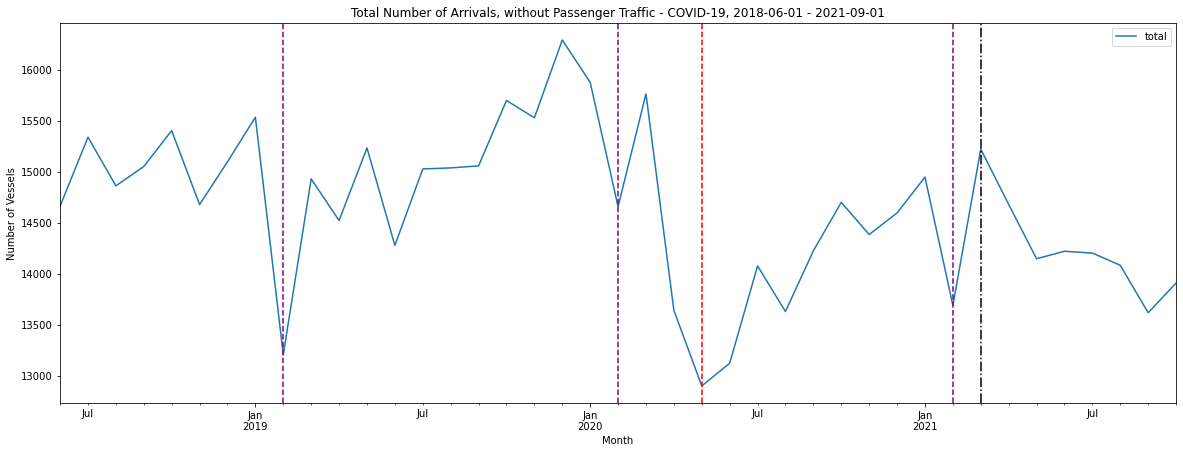

In [33]:
# Total Arrivals - COVID-19 without passengers 
fig_2 = arr_ss.plot("month", "total", figsize = (20,7))
fig_2.set_title('Total Number of Arrivals, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
fig_2.set_xlabel('Month')
fig_2.set_ylabel('Number of Vessels')
fig_2.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_2.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_2.axvline("2020-05-01", color="red", linestyle="dashed")
fig_2.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_2.axvline("2021-03-01", color="black", linestyle="dashdot")

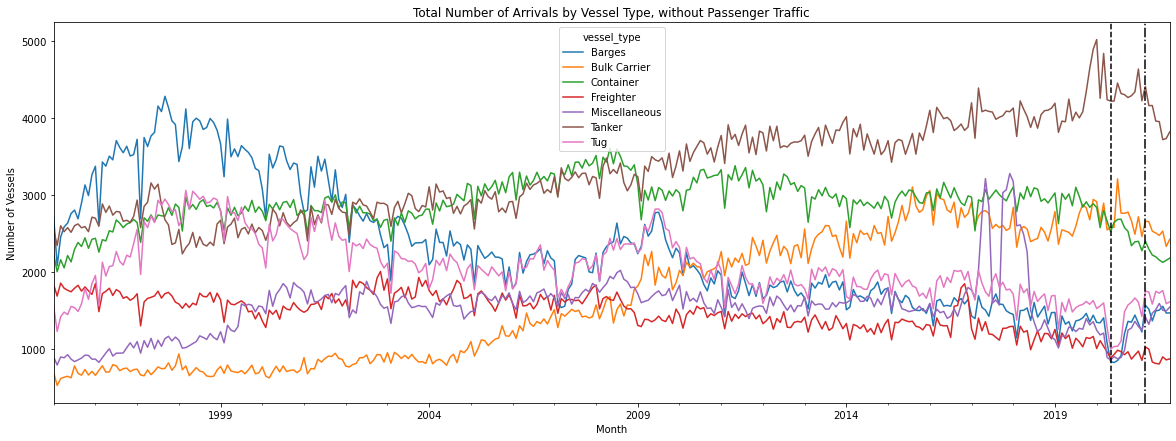

In [36]:
# Arrivals by Vessel Type
fig_3 = arr_df.plot('month', ['Barges', 
                              'Bulk Carrier', 
                              'Container', 
                              'Freighter', 
                              'Miscellaneous', 
                              'Tanker', 
                              'Tug'],
                   figsize = (20,7))
fig_3.set_title('Total Number of Arrivals by Vessel Type, without Passenger Traffic')
fig_3.set_xlabel('Month')
fig_3.set_ylabel('Number of Vessels')
fig_3.axvline("2020-05-01", color="black", linestyle="dashed")
fig_3.axvline("2021-03-01", color="black", linestyle="dashdot")

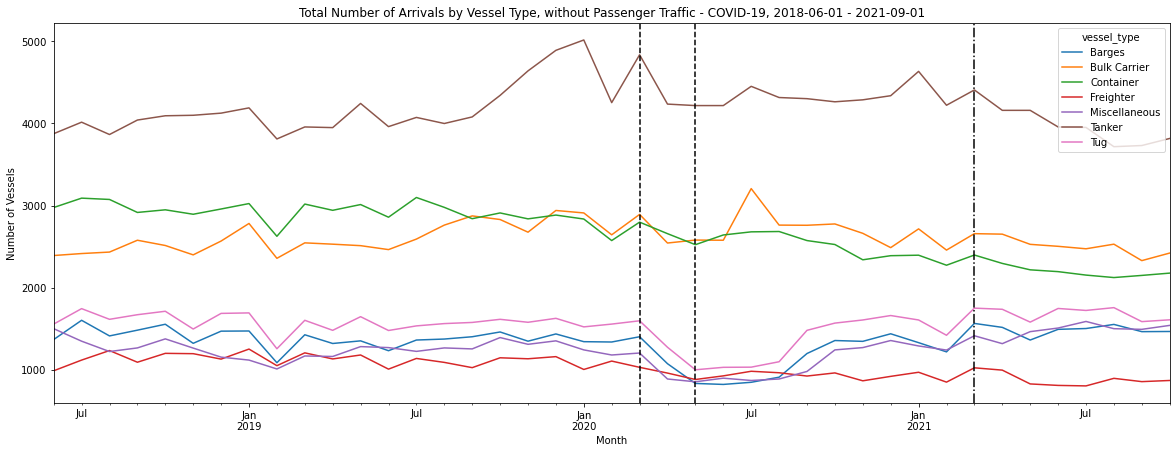

In [37]:
# Arrivals by Vessel Type - COVID-19
fig_4 = arr_ss.plot('month', ['Barges', 
                              'Bulk Carrier', 
                              'Container', 
                              'Freighter', 
                              'Miscellaneous', 
                              'Tanker', 
                              'Tug'],
                   figsize = (20,7))
fig_4.set_title('Total Number of Arrivals by Vessel Type, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
fig_4.set_xlabel('Month')
fig_4.set_ylabel('Number of Vessels')
fig_4.axvline("2020-03-01", color="black", linestyle="dashed")
fig_4.axvline("2020-05-01", color="black", linestyle="dashed")
fig_4.axvline("2021-03-01", color="black", linestyle="dashdot")

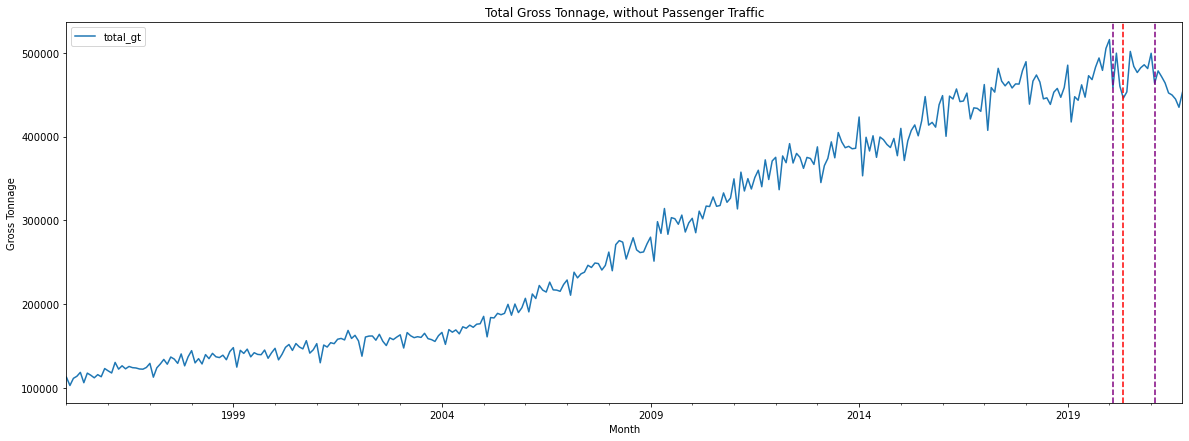

In [38]:
# Total Gross Tonnage
fig_5 = arr_dfg.plot("month", "total_gt", figsize = (20,7))
fig_5.set_title('Total Gross Tonnage, without Passenger Traffic')
fig_5.set_xlabel('Month')
fig_5.set_ylabel('Gross Tonnage')
fig_5.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_5.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_5.axvline("2020-05-01", color="red", linestyle="dashed")

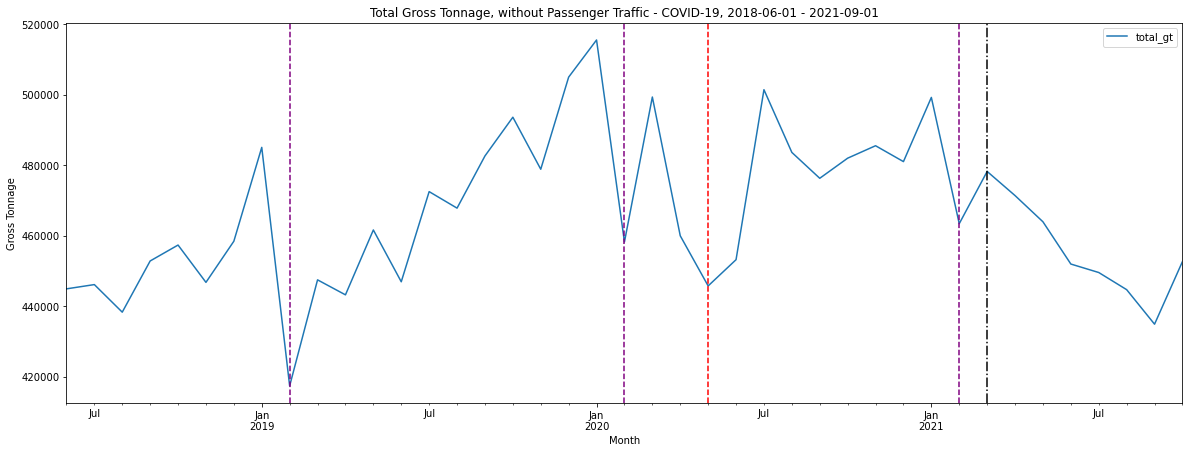

In [40]:
# Total Gross Tonnage - COVID-19
fig_6 = arr_ssg.plot("month", "total_gt", figsize = (20,7))
fig_6.set_title('Total Gross Tonnage, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
fig_6.set_xlabel('Month')
fig_6.set_ylabel('Gross Tonnage')
fig_6.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_6.axvline("2020-05-01", color="red", linestyle="dashed")
fig_6.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_6.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_6.axvline("2021-03-01", color="black", linestyle="dashdot")

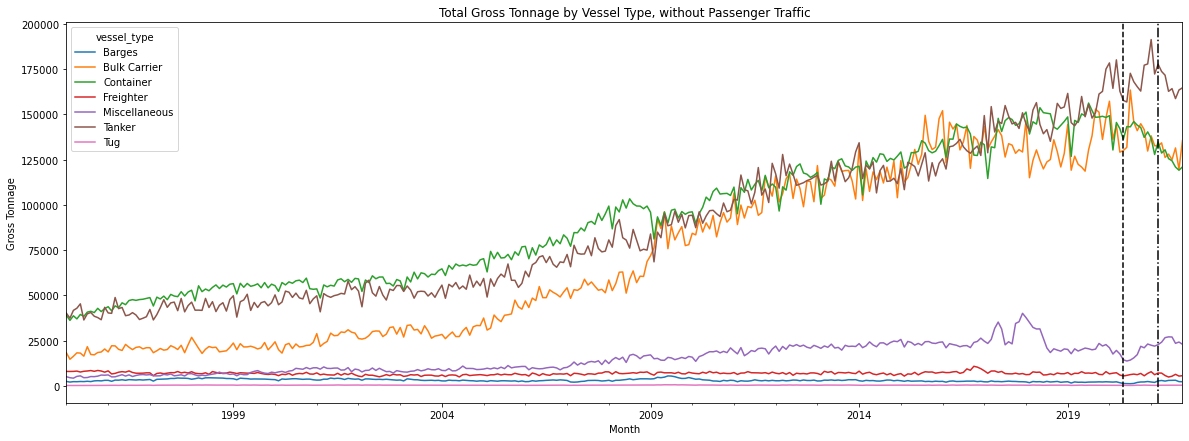

In [41]:
# Gross Tonnage by Vessel Type
fig_7 = arr_dfg.plot('month', ['Barges', 
                              'Bulk Carrier', 
                              'Container', 
                              'Freighter', 
                              'Miscellaneous', 
                              'Tanker', 
                              'Tug'],
                   figsize = (20,7))
fig_7.set_title('Total Gross Tonnage by Vessel Type, without Passenger Traffic')
fig_7.set_xlabel('Month')
fig_7.set_ylabel('Gross Tonnage')
fig_7.axvline("2020-05-01", color="black", linestyle="dashed")
fig_7.axvline("2021-03-01", color="black", linestyle="dashdot")

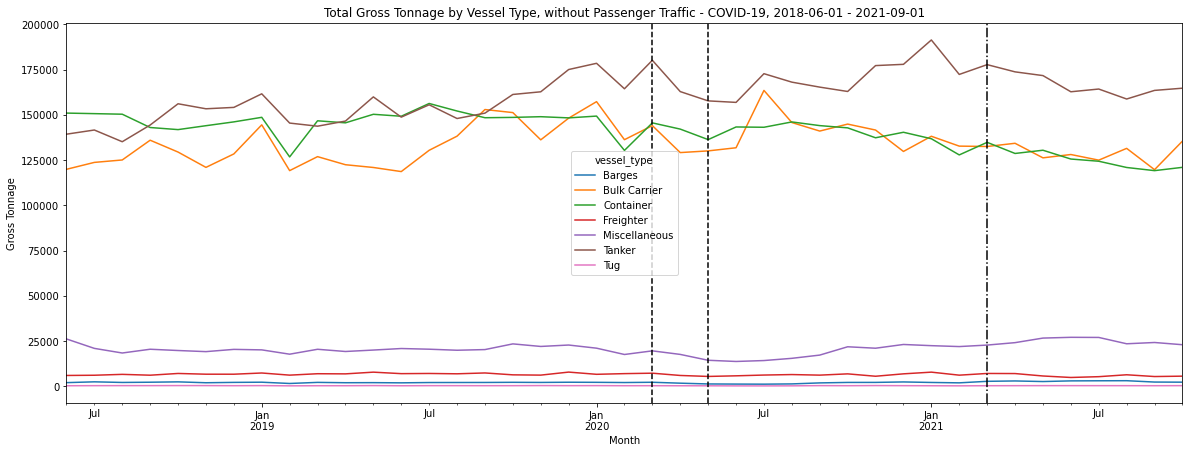

In [42]:
# Gross Tonnage by Vessel Type - COVID-19
fig_8 = arr_ssg.plot('month', ['Barges', 
                              'Bulk Carrier', 
                              'Container', 
                              'Freighter', 
                              'Miscellaneous', 
                              'Tanker', 
                              'Tug'],
                   figsize = (20,7))
fig_8.set_title('Total Gross Tonnage by Vessel Type, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
fig_8.set_xlabel('Month')
fig_8.set_ylabel('Gross Tonnage')
fig_8.axvline("2020-03-01", color="black", linestyle="dashed")
fig_8.axvline("2020-05-01", color="black", linestyle="dashed")
fig_8.axvline("2021-03-01", color="black", linestyle="dashdot")

(0.0, 550000.0)

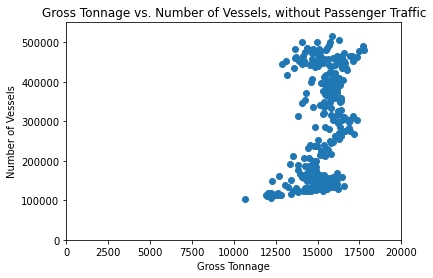

In [52]:
# Gross Tonnage vs. Arrivals
plt.scatter(arr_df['total'], arr_dfg['total_gt'])
plt.title('Gross Tonnage vs. Number of Vessels, without Passenger Traffic')
plt.xlabel('Gross Tonnage')
plt.ylabel('Number of Vessels')
plt.xlim(0, 20000)
plt.ylim(0, 550000)

(0.0, 550000.0)

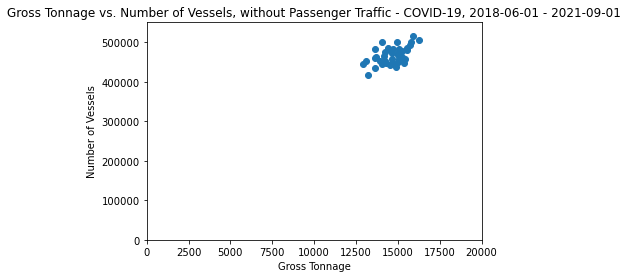

In [53]:
# Gross Tonnage vs. Arrivals - COVID-19
plt.scatter(arr_ss['total'], arr_ssg['total_gt'])
plt.title('Gross Tonnage vs. Number of Vessels, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
plt.xlabel('Gross Tonnage')
plt.ylabel('Number of Vessels')
plt.xlim(0, 20000)
plt.ylim(0, 550000)

(0.0, 550000.0)

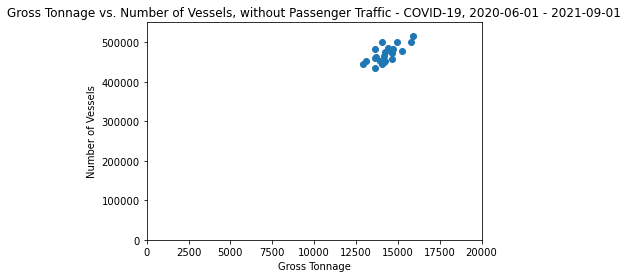

In [55]:
# Gross Tonnage vs. Arrivals - COVID-19 --> greater zoom in
is_covid3 = arr_df['month'] > '2019-12-01'
arr_ss2 = arr_df[is_covid3]
is_covid4 = arr_dfg['month'] > '2019-12-01'
arr_ssg2 = arr_dfg[is_covid3]
plt.scatter(arr_ss2['total'], arr_ssg2['total_gt'])
plt.title('Gross Tonnage vs. Number of Vessels, without Passenger Traffic - COVID-19, 2020-06-01 - 2021-09-01')
plt.xlabel('Gross Tonnage')
plt.ylabel('Number of Vessels')
plt.xlim(0, 20000)
plt.ylim(0, 550000)

In [58]:
# # Gross Tonnage vs. Arrivals by Vessel Type - WILL NOT BE IN REPORT

# # Get merged table
# arr_dfg_fin = arr_dfg.rename(columns={'Barges':'Barges_gt',
#                                       'Bulk Carrier':'Bulk Carrier_gt', 
#                                       'Container':'Container_gt',
#                                       'Freighter': 'Freighter_gt', 
#                                       'Miscellaneous': 'Miscellaneous_gt',
#                                       'Tanker':'Tanker_gt',
#                                       'Tug': 'Tug_gt'})
# gt_nv_1 =  arr_dfg_fin.merge(arr_df, on = 'month')

# # Make Scatter Plot 
# fig, axes = plt.subplots(4,2, figsize = (15,35), sharex='col', sharey='row')
# fig.suptitle('Gross Tonnage vs. Number of Vessels, by Vessel Type')
# axes[0,0].set_title('GT vs NV, Barges')
# axes[0,0].scatter(gt_nv_1['Barges_gt'], gt_nv_1['Barges'])
# axes[0,0].set_xlabel('Gross Tonnage')
# axes[0,0].set_ylabel('Number of Vessels')
# axes[0,0].set_xlim(0, 550000)
# axes[0,0].set_ylim(0, 27000)

# axes[0,1].set_title('GT vs NV, Bulk Carrier')
# axes[0,1].scatter(gt_nv_1['Bulk Carrier_gt'], gt_nv_1['Bulk Carrier'])
# axes[0,1].set_xlabel('Gross Tonnage')
# axes[0,1].set_ylabel('Number of Vessels')
# axes[0,1].set_xlim(0, 550000)
# axes[0,1].set_ylim(0, 27000)

# axes[1,0].set_title('GT vs NV, Container')
# axes[1,0].scatter(gt_nv_1['Container_gt'], gt_nv_1['Container'])
# axes[1,0].set_xlabel('Gross Tonnage')
# axes[1,0].set_ylabel('Number of Vessels')
# axes[1,0].set_xlim(0, 550000)
# axes[1,0].set_ylim(0, 27000)

# axes[1,1].set_title('GT vs NV, Freighter')
# axes[1,1].scatter(gt_nv_1['Freighter_gt'], gt_nv_1['Freighter'])
# axes[1,1].set_xlabel('Gross Tonnage')
# axes[1,1].set_ylabel('Number of Vessels')
# axes[1,1].set_xlim(0, 550000)
# axes[1,1].set_ylim(0, 27000)

# axes[2,0].set_title('GT vs NV, Miscellaneous')
# axes[2,0].scatter(gt_nv_1['Miscellaneous_gt'], gt_nv_1['Miscellaneous'])
# axes[2,0].set_xlabel('Gross Tonnage')
# axes[2,0].set_ylabel('Number of Vessels')
# axes[2,0].set_xlim(0, 550000)
# axes[2,0].set_ylim(0, 27000)

# axes[2,1].set_title('GT vs NV, Tanker')
# axes[2,1].scatter(gt_nv_1['Tanker_gt'], gt_nv_1['Tanker'])
# axes[2,1].set_xlabel('Gross Tonnage')
# axes[2,1].set_ylabel('Number of Vessels')
# axes[2,1].set_xlim(0, 550000)
# axes[2,1].set_ylim(0, 27000)

# axes[3,0].set_title('GT vs NV, Tug')
# axes[3,0].scatter(gt_nv_1['Tug_gt'], gt_nv_1['Tug'])
# axes[3,0].set_xlabel('Gross Tonnage')
# axes[3,0].set_ylabel('Number of Vessels')
# axes[3,0].set_xlim(0, 550000)
# axes[3,0].set_ylim(0, 27000)


In [59]:
# # Gross Tonnage vs. Arrivals by Vessel Type - COVID-19 - WILL NOT BE IN REPORT
# arr_ssg_fin = arr_ssg.rename(columns={'Barges':'Barges_gt',
#                                       'Bulk Carrier':'Bulk Carrier_gt', 
#                                       'Container':'Container_gt',
#                                       'Freighter': 'Freighter_gt', 
#                                       'Miscellaneous': 'Miscellaneous_gt',
#                                       'Tanker':'Tanker_gt',
#                                       'Tug': 'Tug_gt'})
# gt_nv_2 =  arr_ssg_fin.merge(arr_ss, on = 'month')

# # Make Scatter Plot 
# fig, axes = plt.subplots(4,2, figsize = (20,40), sharex='col', sharey='row')
# fig.suptitle('Gross Tonnage vs. Number of Vessels, by Vessel Type')
# axes[0,0].set_title('GT vs NV, Barges')
# axes[0,0].scatter(gt_nv_2['Barges_gt'], gt_nv_2['Barges'])
# axes[0,0].set_xlabel('Gross Tonnage')
# axes[0,0].set_ylabel('Number of Vessels')
# axes[0,0].set_xlim(0, 550000)
# axes[0,0].set_ylim(0, 27000)

# axes[0,1].set_title('GT vs NV, Bulk Carrier')
# axes[0,1].scatter(gt_nv_2['Bulk Carrier_gt'], gt_nv_2['Bulk Carrier'])
# axes[0,1].set_xlabel('Gross Tonnage')
# axes[0,1].set_ylabel('Number of Vessels')
# axes[0,1].set_xlim(0, 550000)
# axes[0,1].set_ylim(0, 27000)

# axes[1,0].set_title('GT vs NV, Container')
# axes[1,0].scatter(gt_nv_2['Container_gt'], gt_nv_2['Container'])
# axes[1,0].set_xlabel('Gross Tonnage')
# axes[1,0].set_ylabel('Number of Vessels')
# axes[1,0].set_xlim(0, 550000)
# axes[1,0].set_ylim(0, 27000)

# axes[1,1].set_title('GT vs NV, Freighter')
# axes[1,1].scatter(gt_nv_2['Freighter_gt'], gt_nv_2['Freighter'])
# axes[1,1].set_xlabel('Gross Tonnage')
# axes[1,1].set_ylabel('Number of Vessels')
# axes[1,1].set_xlim(0, 550000)
# axes[1,1].set_ylim(0, 27000)

# axes[2,0].set_title('GT vs NV, Miscellaneous')
# axes[2,0].scatter(gt_nv_2['Miscellaneous_gt'], gt_nv_2['Miscellaneous'])
# axes[2,0].set_xlabel('Gross Tonnage')
# axes[2,0].set_ylabel('Number of Vessels')
# axes[2,0].set_xlim(0, 550000)
# axes[2,0].set_ylim(0, 27000)

# axes[2,1].set_title('GT vs NV, Tanker')
# axes[2,1].scatter(gt_nv_2['Tanker_gt'], gt_nv_2['Tanker'])
# axes[2,1].set_xlabel('Gross Tonnage')
# axes[2,1].set_ylabel('Number of Vessels')
# axes[2,1].set_xlim(0, 550000)
# axes[2,1].set_ylim(0, 27000)

# axes[3,0].set_title('GT vs NV, Tug')
# axes[3,0].scatter(gt_nv_2['Tug_gt'], gt_nv_2['Tug'])
# axes[3,0].set_xlabel('Gross Tonnage')
# axes[3,0].set_ylabel('Number of Vessels')
# axes[3,0].set_xlim(0, 550000)
# axes[3,0].set_ylim(0, 27000)


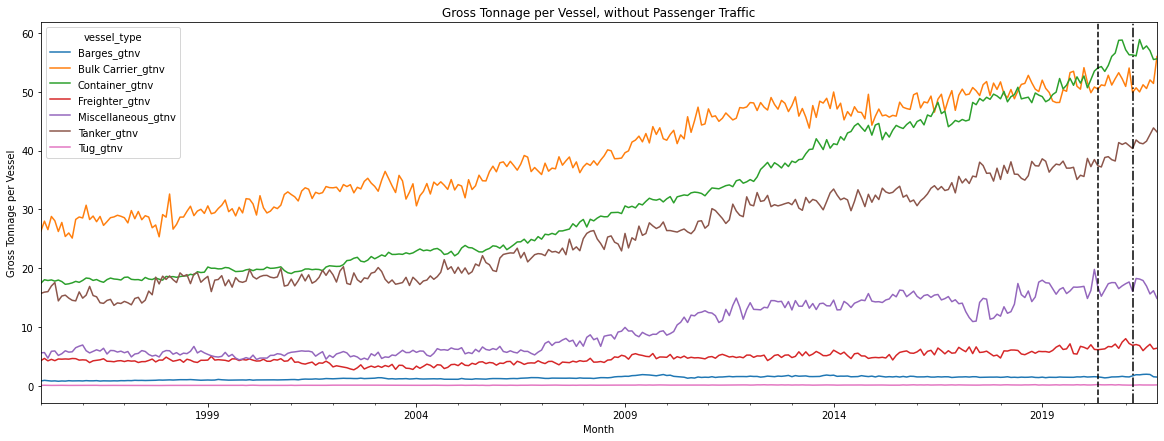

In [74]:
# Gross Tonnage by Vessel - Full Time Period 
# Get merged table
arr_dfg_fin = arr_dfg.rename(columns={'Barges':'Barges_gt',
                                      'Bulk Carrier':'Bulk Carrier_gt', 
                                      'Container':'Container_gt',
                                      'Freighter': 'Freighter_gt', 
                                      'Miscellaneous': 'Miscellaneous_gt',
                                      'Tanker':'Tanker_gt',
                                      'Tug': 'Tug_gt'})
gt_nv_13 =  arr_dfg_fin.merge(arr_df, on = 'month')

# Add it additional columns for gt/nv
gt_nv_13['Barges_gtnv'] = gt_nv_13['Barges_gt']/ gt_nv_13['Barges']
gt_nv_13['Bulk Carrier_gtnv'] = gt_nv_13['Bulk Carrier_gt']/ gt_nv_13['Bulk Carrier']
gt_nv_13['Container_gtnv'] = gt_nv_13['Container_gt']/ gt_nv_13['Container']
gt_nv_13['Freighter_gtnv'] = gt_nv_13['Freighter_gt']/ gt_nv_13['Freighter']
gt_nv_13['Miscellaneous_gtnv'] = gt_nv_13['Miscellaneous_gt']/ gt_nv_13['Miscellaneous']
gt_nv_13['Tanker_gtnv'] = gt_nv_13['Tanker_gt']/ gt_nv_13['Tanker']
gt_nv_13['Tug_gtnv'] = gt_nv_13['Tug_gt']/ gt_nv_13['Tug']


# Make Line Plot 
fig_10 = gt_nv_13.plot("month", ['Barges_gtnv','Bulk Carrier_gtnv', 'Container_gtnv', 'Freighter_gtnv','Miscellaneous_gtnv', 'Tanker_gtnv','Tug_gtnv'], figsize = (20,7))
fig_10.set_title('Gross Tonnage per Vessel, without Passenger Traffic')
fig_10.set_xlabel('Month')
fig_10.set_ylabel('Gross Tonnage per Vessel')
fig_10.axvline("2020-05-01", color="black", linestyle="dashed")
fig_10.axvline("2021-03-01", color="black", linestyle="dashdot")

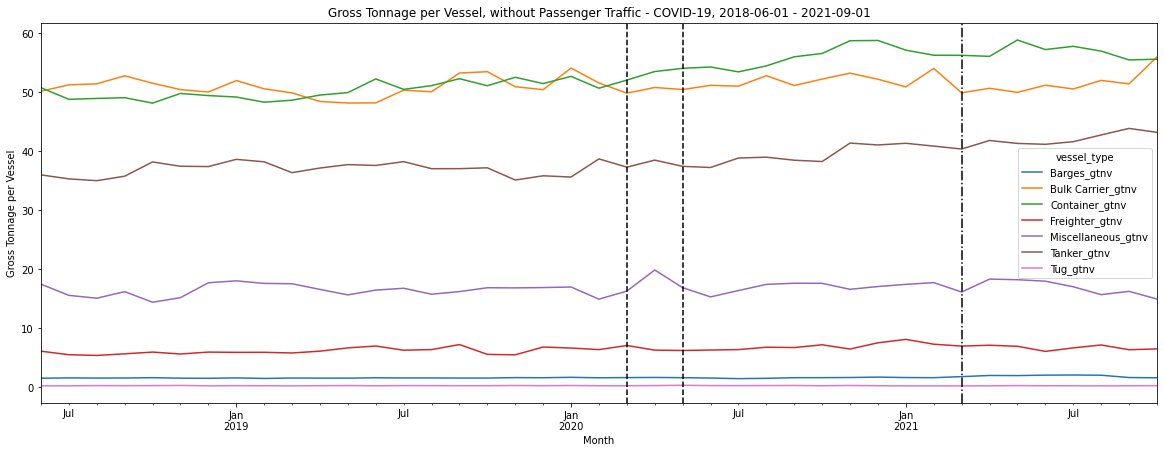

In [75]:
# Gross Tonnage per Vessel - COVID 19
# Get merged table
arr_ssg_fin = arr_ssg.rename(columns={'Barges':'Barges_gt',
                                      'Bulk Carrier':'Bulk Carrier_gt', 
                                      'Container':'Container_gt',
                                      'Freighter': 'Freighter_gt', 
                                      'Miscellaneous': 'Miscellaneous_gt',
                                      'Tanker':'Tanker_gt',
                                      'Tug': 'Tug_gt'})
gt_nv_2 =  arr_ssg_fin.merge(arr_ss, on = 'month')

# Add it additional columns for gt/nv
gt_nv_2['Barges_gtnv'] = gt_nv_2['Barges_gt']/ gt_nv_2['Barges']
gt_nv_2['Bulk Carrier_gtnv'] = gt_nv_2['Bulk Carrier_gt']/ gt_nv_2['Bulk Carrier']
gt_nv_2['Container_gtnv'] = gt_nv_2['Container_gt']/ gt_nv_2['Container']
gt_nv_2['Freighter_gtnv'] = gt_nv_2['Freighter_gt']/ gt_nv_2['Freighter']
gt_nv_2['Miscellaneous_gtnv'] = gt_nv_2['Miscellaneous_gt']/ gt_nv_2['Miscellaneous']
gt_nv_2['Tanker_gtnv'] = gt_nv_2['Tanker_gt']/ gt_nv_2['Tanker']
gt_nv_2['Tug_gtnv'] = gt_nv_2['Tug_gt']/ gt_nv_2['Tug']


# Make Line Plot 
fig_10 = gt_nv_2.plot("month", ['Barges_gtnv','Bulk Carrier_gtnv', 'Container_gtnv', 'Freighter_gtnv','Miscellaneous_gtnv', 'Tanker_gtnv','Tug_gtnv'], figsize = (20,7))
fig_10.set_title('Gross Tonnage per Vessel, without Passenger Traffic - COVID-19, 2018-06-01 - 2021-09-01')
fig_10.set_xlabel('Month')
fig_10.set_ylabel('Gross Tonnage per Vessel')
fig_10.axvline("2020-03-01", color="black", linestyle="dashed")
fig_10.axvline("2020-05-01", color="black", linestyle="dashed")
fig_10.axvline("2021-03-01", color="black", linestyle="dashdot")

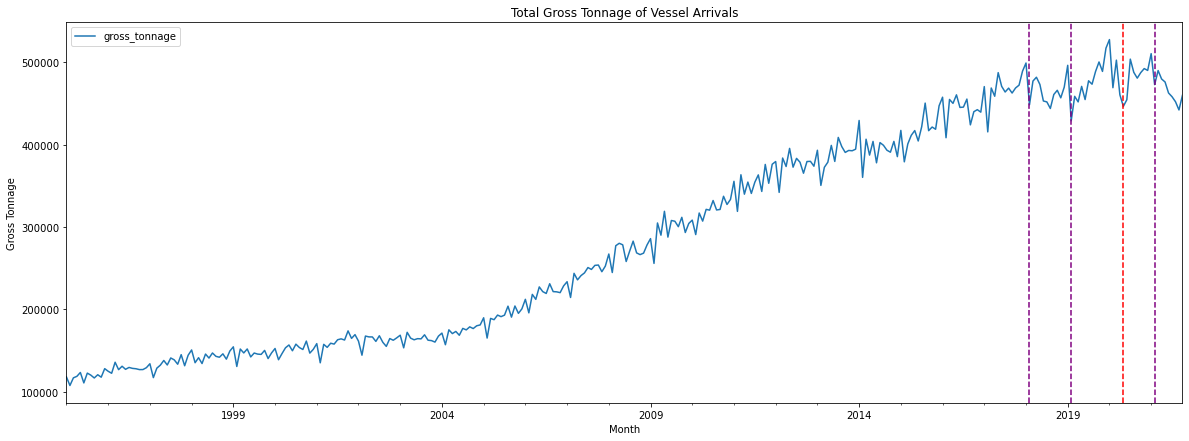

In [76]:
# Total Gross Tonnage with passengers 
arr_df_totp = data['arr_agg']['df']
fig_001 = arr_df_totp.plot("month", "gross_tonnage", figsize = (20,7))
fig_001.set_title('Total Gross Tonnage of Vessel Arrivals')
fig_001.set_xlabel('Month')
fig_001.set_ylabel('Gross Tonnage')
fig_001.axvline("2018-02-01", color="purple", linestyle="dashed")
fig_001.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_001.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_001.axvline("2020-05-01", color="red", linestyle="dashed")

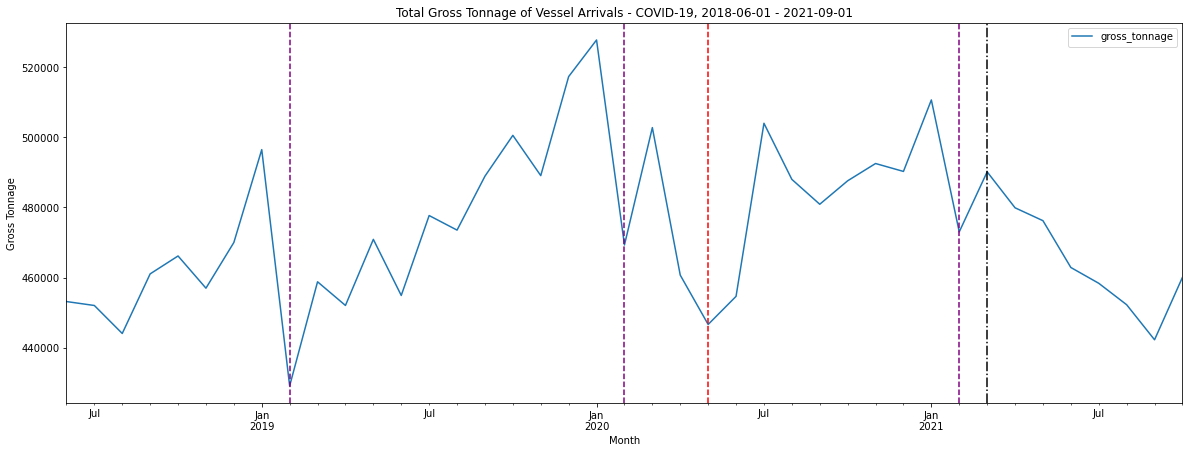

In [77]:
# Total Gross Tonnage - COVID-19 with passengers
arr_df_totp = data['arr_agg']['df']
is_covid02 = arr_df_totp['month'] >= '2018-06-01'
arr_ss_totp = arr_df_totp[is_covid02]
fig_002 = arr_ss_totp.plot("month", "gross_tonnage", figsize = (20,7))
fig_002.set_title('Total Gross Tonnage of Vessel Arrivals - COVID-19, 2018-06-01 - 2021-09-01')
fig_002.set_xlabel('Month')
fig_002.set_ylabel('Gross Tonnage')
fig_002.axvline("2019-02-01", color="purple", linestyle="dashed")
fig_002.axvline("2020-02-01", color="purple", linestyle="dashed")
fig_002.axvline("2020-05-01", color="red", linestyle="dashed")
fig_002.axvline("2021-02-01", color="purple", linestyle="dashed")
fig_002.axvline("2021-03-01", color="black", linestyle="dashdot")

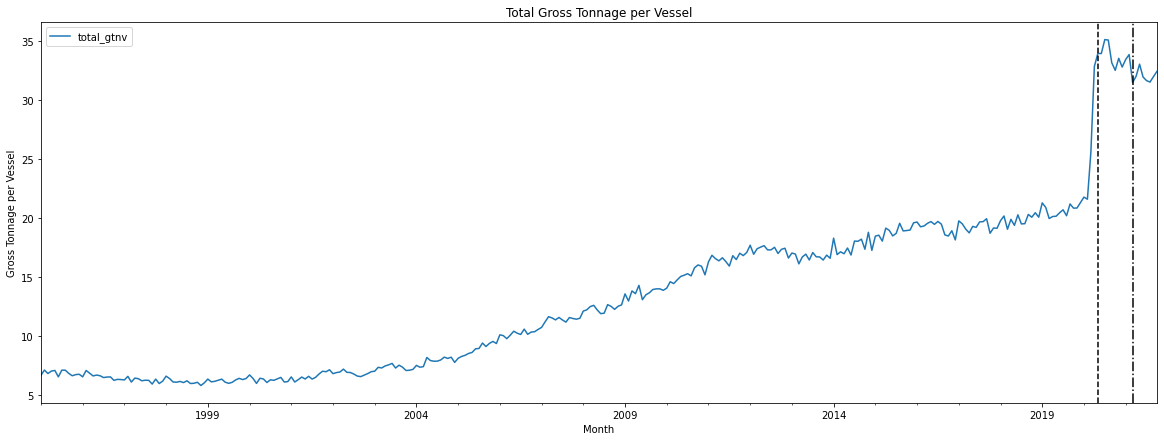

In [80]:
#Get Overall Gross Tonnage per Vessel Arrivals
# Add it additional columns for gt/nv
arr_df_totp['total_gtnv'] = arr_df_totp['gross_tonnage']/ arr_df_totp['number_of_vessels']

# Make Line Plot 
fig_010 = arr_df_totp.plot("month", "total_gtnv", figsize = (20,7))
fig_010.set_title('Total Gross Tonnage per Vessel')
fig_010.set_xlabel('Month')
fig_010.set_ylabel('Gross Tonnage per Vessel')
fig_010.axvline("2020-05-01", color="black", linestyle="dashed")
fig_010.axvline("2021-03-01", color="black", linestyle="dashdot")

/Users/annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


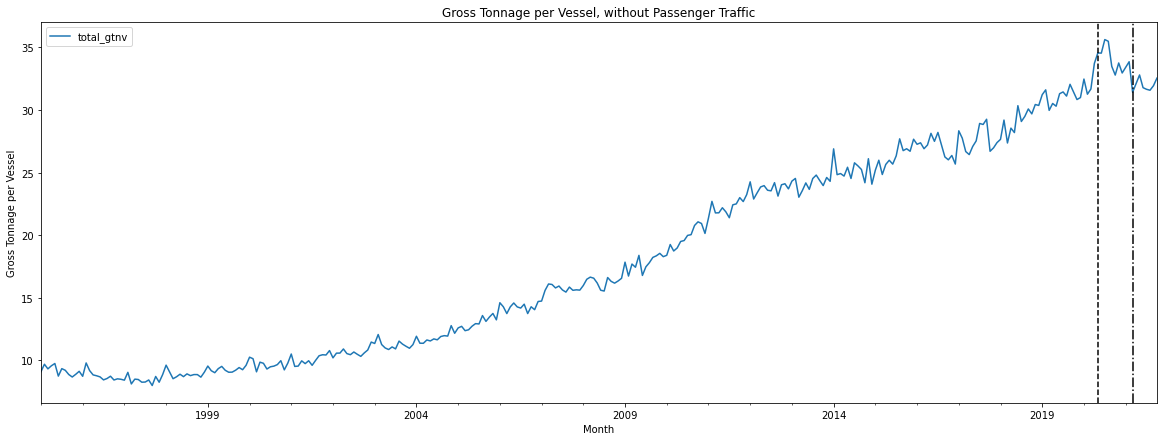

In [81]:
# Total Gross Tonnage without passenger
# arr_df_tot
# fig_5 = arr_df_totgt.plot("month", "total", figsize = (20,7))
# fig_5.set_title('Total Gross Tonnage')
# fig_5.set_xlabel('Month')
# fig_5.set_ylabel('Gross Tonnage')
# fig_5.axvline("2020-02-01", color="purple", linestyle="dashed")
# fig_5.axvline("2021-02-01", color="purple", linestyle="dashed")
# fig_5.axvline("2020-05-01", color="red", linestyle="dashed")

# Make data frame for chart - simplified version 
gt_nvt =  arr_df.merge(arr_dfg, on = 'month')
gt_nvt_fin = gt_nvt[['month', 'total', 'total_gt']]

# # Add it additional columns for gt/nv
gt_nvt_fin['total_gtnv'] = gt_nvt_fin['total_gt']/ gt_nvt_fin['total']

# Make Line Plot 
fig_100 = gt_nvt_fin.plot("month", "total_gtnv", figsize = (20,7))
fig_100.set_title('Total Gross Tonnage per Vessel, without Passenger Traffic')
fig_100.set_xlabel('Month')
fig_100.set_ylabel('Gross Tonnage per Vessel')
fig_100.axvline("2020-05-01", color="black", linestyle="dashed")
fig_100.axvline("2021-03-01", color="black", linestyle="dashdot")